# This notebook is primarily a testing ground used while developing new functionality. Some examples of how to use the functions can be found here, but the notebook is not intended as guide/documentation

In [2]:
import numpy as np 
import pandas as pd

import ExcessMortalityFunctions as emf
from importlib import reload
reload(emf)

from scipy.stats import poisson

import matplotlib.pyplot as plt


# import sys
 
# # setting path
# sys.path.append('../Functions')
# import PandemiXSignaturesForSubfolders as ps

# Generate dataset for testing with large numbers

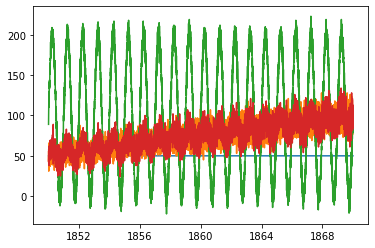

In [29]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1870-01-01')
ts = np.arange(d1,d2)

# Constant
curMean = 50 
curBase = poisson.rvs(curMean,size = len(ts))
curBase = curMean * np.ones(len(ts))

# Linearly increasing
curMean2 = 100
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 100
sinPer = 2*np.pi/365.25
# curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))
curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer) + sinAmp/2)


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase4 = np.round(poisson.rvs(allMeans,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))

# Plot
fig,ax = plt.subplots()
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [30]:

df = pd.DataFrame(
    index = ts,
    data={
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)

# df.plot()


# New tests of functions

In [35]:
%matplotlib widget

In [54]:
rawData = df.Base2.copy()

# np.random.rand(df.Base2)

rawData[rawData.sample(200).index] = 10 * rawData[rawData.sample(200).index] 

rawData[4000:4060]  = 200

In [56]:
rawData = emf.groupByMonth(rawData)

Iteration 1 of removing larger crises. 5 found.
Iteration 2 of removing larger crises. 1 found.
Iteration 3 of removing larger crises. 0 found.
Iteration 1 of removing larger crises. 5 found.
Iteration 2 of removing larger crises. 1 found.
Iteration 3 of removing larger crises. 0 found.


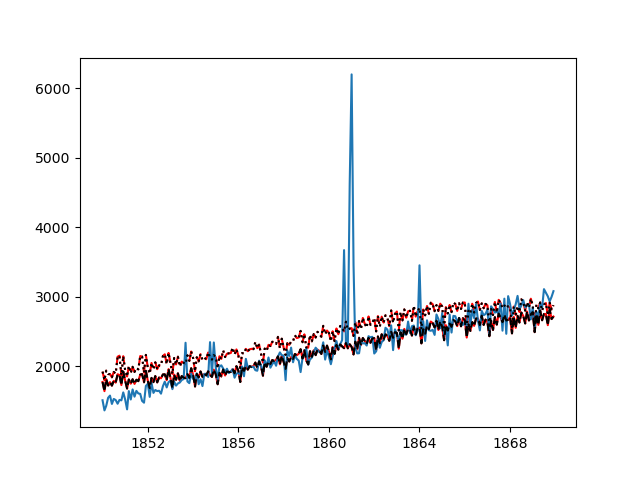

In [57]:
fig,ax = plt.subplots()

curMean,curStd = emf.rnMean(rawData)
curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeat(rawData,curMean,curStd,verbose=True)
ax.plot(curMean,'r')
ax.plot(curMean+curStd,'r-.')
curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeatFull(rawData,verbose=True)
# ax.plot(emf.groupByMonth(curData))
ax.plot(curData)
ax.plot(curMean,'k--')
ax.plot(curMean+curStd,'k:')

# STL test

In [4]:



from statsmodels.tsa.seasonal import STL

# fft test

In [4]:
%matplotlib widget



In [ ]:

tDays = (ts -ts[0])/np.timedelta64(1,'D')
curMean = 2
sinAmp = 1
sinPer = 2*np.pi/365.25
# curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))
# curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer) + sinAmp/2)
curBase3 = np.round(poisson.rvs(curMean + sinAmp * np.sin(tDays * sinPer) + sinAmp/2,size = len(ts)))

# curData = df.Base3.values 
# curTs = (ts-ts[0])/np.timedelta64(1,'D')
curData = curBase3[:2000]
curTs = tDays[:2000]

sampFreq = 1

curfft = np.fft.fft(curData)/len(curData)

# # curfft
curfft = curfft[range(int(len(curData)/2))]

tpCount = len(curData)
values = np.arange(int(tpCount/2))
timeP = tpCount/sampFreq  
freqs = values/timeP



fig,(ax,ax2) = plt.subplots(2,1)

ax.plot(curTs,curData)
ax2.plot(1/freqs,np.abs(curfft))
ax2.set_xlim([0,600])
# np.abs(curfft)

In [ ]:

# ax.plot(df.Base3)

curData = df.Base3.values 
# testDays = np.arange(200)
# testDays = np.linspace(0,200,1000)
# testDays = np.linspace(0,10,1000)
tEnd = 360*30
sampFreq = 1

testDays = np.arange(0,tEnd,1/sampFreq)
freq1 = 1/360
freq2 = 1/30

curData = ( 0.9* np.sin(testDays * 2 *np.pi * freq1) + 0.1* np.sin(testDays * 2 *np.pi * freq2))
curfft = np.fft.fft(curData)/len(curData)

# curfft
curfft = curfft[range(int(len(curData)/2))]

tpCount = len(curData)
values = np.arange(int(tpCount/2))
timeP = tpCount/sampFreq  
freqs = values/timeP

# 
fig,(ax,ax2) = plt.subplots(2,1)
ax.plot(testDays,curData)  
ax.plot(testDays,np.sin(testDays * 2 *np.pi * freq1),lw=.1)
ax.plot(testDays,np.sin(testDays * 2 *np.pi * freq2),lw=.1)

# ax.set_xlim([0,2])
# sinPer
ax2.plot(1/freqs,np.abs(curfft))


# Serfling model tests

In [ ]:
# curData = df.Base3
# monData = emf.groupByMonth(curData)

# fig,ax = plt.subplots()
# ax.plot(monData)

# Test 

In [5]:
ys = np.arange(
    np.datetime64('1850'),
    np.datetime64('1880'),
)
dfTest = pd.DataFrame(
    index=ys,
    data={
        'Base':10000 * np.ones(len(ys))
    }
)
# dfTest


In [6]:
dfTest.iloc[14] = np.nan 
dfTest

,Base
1850-01-01,10000.0
1851-01-01,10000.0
1852-01-01,10000.0
1853-01-01,10000.0
1854-01-01,10000.0
1855-01-01,10000.0
1856-01-01,10000.0
1857-01-01,10000.0
1858-01-01,10000.0
1859-01-01,10000.0


In [7]:
reload(emf)

<module 'ExcessMortalityFunctions' from 'c:\\NonSyncedFiles\\GithubRepos\\ExcessMortality\\ExcessMortalityFunctions.py'>

In [8]:

curData = dfTest.Base
curData = df.Base
numYears = 5
# # curMean,curStd = emf.rnMean(curData,numYears = numYears,timeResolution='Year')

# pdSeries = curData 
# serYear = pdSeries.groupby(pdSeries.index.year.rename('Year')).sum(min_count=1)
# serYear
# # pdSeries
# # pdSeries.groupby(pdSeries.index.year.rename('Year'))


In [9]:


# curRolling = serYear.rolling(window=(numYears*2)+1,center=True,min_periods=1)
# curSum = curRolling.sum()
# curCount = curRolling.count()

# # curCount = (curCount + serYear.isna() * 1) 
# # serYear.rolling(window=11,center=True,min_periods=1).count()

# curMean = (curSum - serYear.fillna(0))/(curCount-serYear.notna()*1)

# # curMean
# # curCount
# # curSum - serYear.fillna(0)
# # curCount-1
# # (curCount + serYear.isna() * 1) - 1
# # curMean
# # curSum
# # serYear.notna()*1

# # Reshape pivottables into series
# curMean = curMean.reset_index()
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=np.ones(len(curMean.Year)),day=np.ones(len(curMean.Year))))
# curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year']).rename(columns={'value':'Baseline'}).iloc[:,0]

In [10]:

curData = dfTest.Base
curData = df.Base3

curData = emf.removeLeapDays(curData)

curMean,curStd = emf.rnMean(curData,numYears = 5,timeResolution='Year')

curData = emf.groupByYear(curData)

In [11]:
# fig,ax = plt.subplots()
# ax.plot(df.Base3)

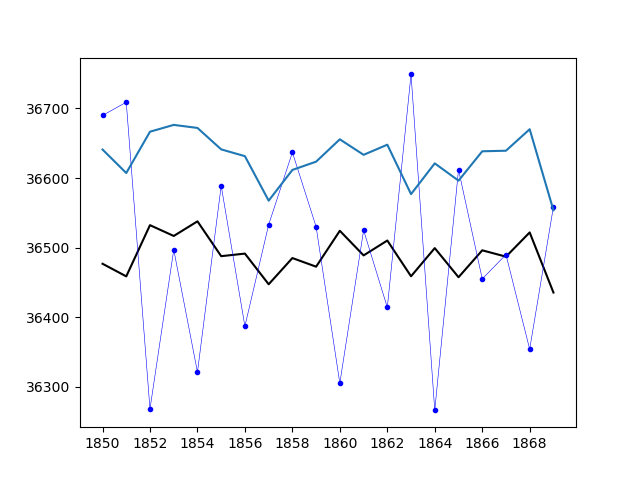

In [12]:

fig,ax = plt.subplots()
ax.plot(curMean,'k')
ax.plot(curData,'b.-',lw=0.4)
ax.plot(curMean+curStd)

# Tests with outliers below

In [13]:
reload(emf)
%matplotlib widget
numYears = 12

In [14]:
dfOut = df.copy()

len(dfOut)
indexToIncrease = np.random.randint(0,len(dfOut),100)

dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:]*4
# dfOut

In [47]:
# curData = dfOut.Base4
# curMean,curStd = emf.rnMean(curData,numYears = 12,timeResolution='Month')
# curData = emf.groupByMonth(curData)

curData = dfOut.Base4
curData = curData.rolling(window=7,center=True).mean()

# fig,ax = plt.subplots()
# ax.plot(curData,'.-',ms=2,color='b',lw=0.5)
numYears = 12
curMean,curStd = emf.rnMean(curData,numYears = numYears,timeResolution='Day')



In [48]:
curExc,curZsc,curExcPct = emf.getExcessAndZscore(curData,curMean,curStd)

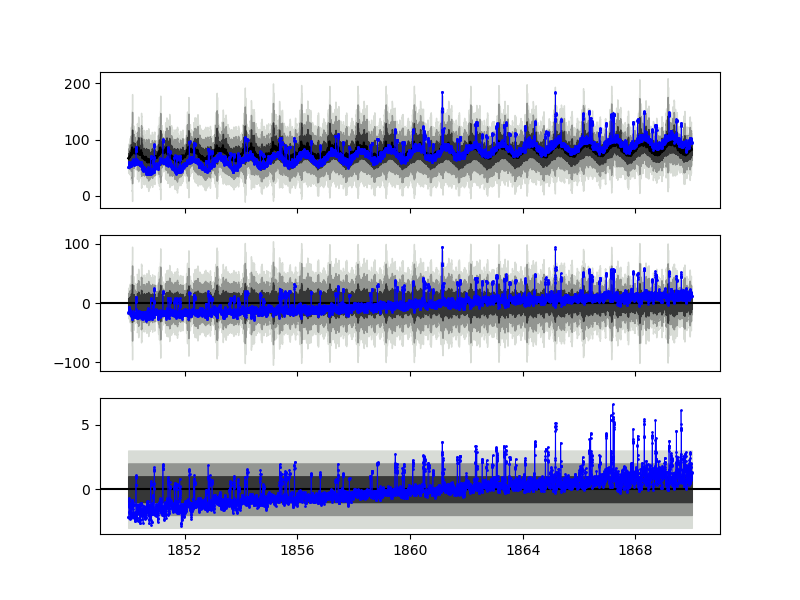

In [50]:
fig,axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
ax1,ax2,ax3 = axs 
ax1.plot(curMean,color='k')
ax1.plot(curData,'.-',ms=2,color='b',lw=0.5)

ax1.fill_between(curData.index,curMean-3*curStd,curMean+3*curStd,color='xkcd:light grey')
ax1.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
ax1.fill_between(curData.index,curMean-curStd,curMean+curStd,color='xkcd:dark grey')


ax2.axhline(0,color='k')
ax2.plot(curExc,'.-',ms=2,color='b',lw=0.5)
ax2.fill_between(curData.index,-3*curStd,+3*curStd,color='xkcd:light grey')
ax2.fill_between(curData.index,-2*curStd,+2*curStd,color='xkcd:grey')
ax2.fill_between(curData.index,-curStd,+curStd,color='xkcd:dark grey')


ax3.axhline(0,color='k')
ax3.plot(curZsc,'.-',ms=2,color='b',lw=0.5)
ax3.fill_between(curData.index,-3*np.ones(curStd.shape),+3*np.ones(curStd.shape),color='xkcd:light grey')
ax3.fill_between(curData.index,-2*np.ones(curStd.shape),+2*np.ones(curStd.shape),color='xkcd:grey')
ax3.fill_between(curData.index,-np.ones(curStd.shape),+np.ones(curStd.shape),color='xkcd:dark grey')



# ax1.set_xlim([
#     np.datetime64('1865-01-01'),
#     np.datetime64('1870-01-01')
# ])
# ax1.plot(curData.loc[curZsc[curZsc > 2].index],'*m')
# ax1.plot(curData.loc[curZsc[curZsc > 3].index],'*r')

In [51]:

from scipy.stats import norm



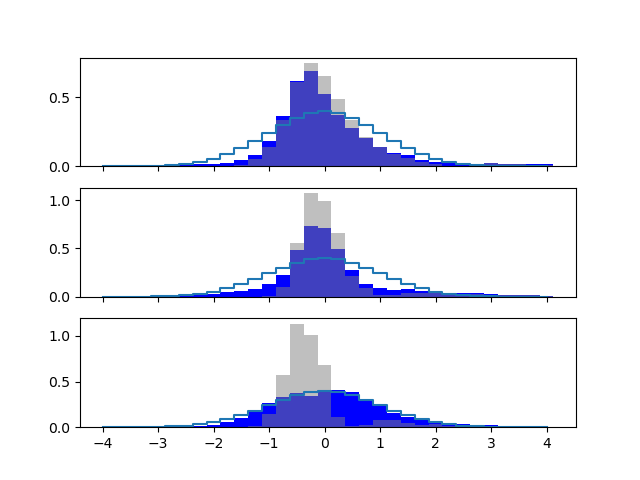

In [52]:
fig,axs = plt.subplots(3,1,sharex=True)
curBins = np.arange(-4,4+0.1,0.25)
# curBins = np.arange(-40,40+0.1,0.25)
# ax.hist(curZsc)

d1 = np.datetime64('1855')
d2 = np.datetime64('1860')

numYears = 5
for i,numYears in enumerate([3,6,12]):
    ax = axs.flatten()[i]
    curMean,curStd = emf.rnMean(curData,numYears = numYears,timeResolution='Day')
    curExc,curZsc,curExcPct = emf.getExcessAndZscore(curData,curMean,curStd)

    ax.hist(curZsc,bins=curBins,density=True,color='b',align='right')
    ax.hist(curZsc[d1:d2],bins=curBins,density=True,color=(0.5,0.5,0.5,0.5),align='right')

    ax.step(curBins,norm.pdf(curBins),where='mid')



In [ ]:
curZscoreThreshold = 3

curDataRemove = curData.copy()
curDataRemove.loc[curZsc[curZsc > curZscoreThreshold].index] = np.nan 

# print((curZsc > curZscoreThreshold).sum())
numOutside = (curZsc > curZscoreThreshold).sum()
print(numOutside)

In [ ]:
reload(emf)

In [ ]:
curData = dfOut.Base4.copy()
# curData = curData.rolling(window=7,center=True).mean()
curDataRaw = curData.copy()

In [ ]:
numYears = 12

In [ ]:

# fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
# ax.plot(curData)
# curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')
# ax.fill_between(curMean.index,curMean - 2* curStd,curMean + 2* curStd,color='xkcd:light grey')
# ax.fill_between(curMean.index,curMean - curStd,curMean + curStd,color='xkcd:grey')
# ax.plot(curMean,'k')

# curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeat(curData,curMean,curStd,ZscoreThreshold=2,numYears=numYears,timeResolution='Day')
# ax2.plot(curData)
# ax2.fill_between(curMean.index,curMean - 2* curStd,curMean + 2* curStd,color='xkcd:light grey')
# ax2.fill_between(curMean.index,curMean - curStd,curMean + curStd,color='xkcd:grey')
# ax2.plot(curMean,'k')

In [ ]:

fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')
curExc,curZsc = emf.getExcessAndZscore(curData,curMean,curStd)
ax.plot(curZsc)
ax.fill_between(curMean.index,- 2* np.ones(curStd.shape),+ 2* np.ones(curStd.shape),color='xkcd:light grey')
ax.fill_between(curMean.index,- np.ones(curStd.shape),+ np.ones(curStd.shape),color='xkcd:grey')
# ax.plot(curMean,'k')
ax.plot(curZsc.iloc[indexToIncrease],'*')

curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeat(curData,curMean,curStd,ZscoreThreshold=2,numYears=numYears,timeResolution='Day')
curExc,curZsc = emf.getExcessAndZscore(curData,curMean,curStd)
ax2.plot(curZsc)
ax2.fill_between(curMean.index,- 2* np.ones(curStd.shape),+ 2* np.ones(curStd.shape),color='xkcd:light grey')
ax2.fill_between(curMean.index,- np.ones(curStd.shape),+ np.ones(curStd.shape),color='xkcd:grey')
# ax2.plot(curMean,'k')

ax2.plot(curZsc.iloc[indexToIncrease],'*')

In [ ]:

fig,ax = plt.subplots()
ax.plot(curData)
curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')

for k in range(6):
    curData,curMean,curStd = emf.removeAboveThresholdAndRecalculate(curData,curMean,curStd,ZscoreThreshold=3,numYears=numYears,timeResolution='Day')
    ax.plot(curData,'.-')

In [ ]:
curDataRemove = emf.removeAboveThreshold(curData,curMean,curStd,ZscoreThreshold=3)

fig,ax = plt.subplots()
ax.plot(curData)
ax.plot(curDataRemove,'.-')

In [ ]:

while numOutside > 0:

    curMeanRemove,curStdRemove = emf.rnMean(curDataRemove,numYears = numYears,timeResolution='Day')
    curExcRemove,curZscRemove = emf.getExcessAndZscore(curDataRemove,curMeanRemove,curStdRemove)
    # curExcRemove,curZscRemove = emf.getExcessAndZscore(curData,curMeanRemove,curStdRemove)

    curDataRemove.loc[curZscRemove[curZscRemove > curZscoreThreshold].index] = np.nan 
    numOutside = (curZscRemove > curZscoreThreshold).sum()


    # print((curZscRemove > curZscoreThreshold).sum())
    print(numOutside)

In [ ]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
ax.plot(curMean,color='k')
ax2.plot(curMeanRemove,color='r')
# ax.plot(curDataRemove,'.-',ms=2,color='g',lw=0.5)
ax.plot(curData,'.-',ms=2,color='b',lw=0.5)
ax.plot(curDataRemove,'.-',ms=2,color='g',lw=0.5)
ax2.plot(curData,'.-',ms=2,color='b',lw=0.5)

# ax.plot(curMean + curStd,'m',lw=1)
# ax.plot(curMeanRemove + curStdRemove,'g',lw=1)

ax.fill_between(curData.index,curMean-3*curStd,curMean+3*curStd,color='xkcd:light grey')
ax.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
ax.fill_between(curData.index,curMean-1*curStd,curMean+1*curStd,color='xkcd:dark grey')

ax2.fill_between(curData.index,curMeanRemove-3*curStdRemove,curMeanRemove+3*curStdRemove,color='xkcd:light grey')
ax2.fill_between(curData.index,curMeanRemove-2*curStdRemove,curMeanRemove+2*curStdRemove,color='xkcd:grey')
ax2.fill_between(curData.index,curMeanRemove-1*curStdRemove,curMeanRemove+1*curStdRemove,color='xkcd:dark grey')

In [ ]:

# # Add columns for year, month and day
# curFrame = dfOut.Base.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day

# # Organize as pivot-table (with multi-columns)
# curPivot = curFrame.pivot_table(values=dfOut.Base.name,columns=['Month','Day'],index='Year')
# curPivot

In [ ]:

# # Add columns for year, month and day
# curFrame = curData.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day

# # Organize as pivot-table (with multi-columns)
# curPivot = curFrame.pivot_table(values=curData.name,columns=['Month','Day'],index='Year')
# curPivot

In [ ]:

# curDataRemoveNoRoll = dfOut.Base
# curDataRemove = curDataRemoveNoRoll.copy()
# curDataRemove = curDataRemove.rolling(window=7,center=True).mean()

numYears = 5
# Add columns for year, month and day
curFrame = curDataRemove.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curDataRemove.name,columns=['Month','Day'],index='Year')
# curPivot


# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum()
curCount = curRolling.count()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot.fillna(0))/(curCount-1)
# curSum
# curCount-1

# Calculate the sum of squares of surrounding years and current year
curRollingSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSumSqr = curRollingSqr.sum()
curMeanSqr = (curSumSqr - curPivot.pow(2).fillna(0))/(curCount-1)


# curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
# curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2).fillna(0)).pow(0.5)

curStd
curSumSqr - curPivot.pow(2).fillna(0)
# curCount
curMeanSqr

In [ ]:
# curPivot
# curCount -1
# curSum - curPivot.fillna(0)
# curSumSqr - curPivot.pow(2).fillna(0)
# curMeanSqr
# curMeanSqr - curMean.pow(2).fillna(0)
# curMean
# curCount

# curPivot

In [ ]:
numYears = 5
# Add columns for year, month and day
curFrame = curDataRemove.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curDataRemove.name,columns=['Month','Day'],index='Year')
curPivot

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum()
curCount = curRolling.count()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot.fillna(0))/(curCount-1)
# curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curRollingSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSumSqr = curRollingSqr.sum()
curMeanSqr = (curSumSqr - curPivot.pow(2).fillna(0))/(curCount-1)


# curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
# curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2).fillna(0)).pow(0.5)

# curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=numYears).count()
# curSum/curCount
# curRolling.mean()
# curCount
# curMean

# curPivot
# curSum - curPivot.fillna(0)

# curRollingSqr.sum()
# curMeanSqr - curM 
# curMeanScurMean.pow(2)
# curStd
curMeanSqr - curMean.pow(2).fillna(0)

curCount 

In [ ]:

# For leap days, use the average of February 28th and March 1st (Leap-days in non-leap-years will be removed below anyways)
curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curStd.loc[:,(2,29)] = (curStd.loc[:,(2,28)] + curStd.loc[:,(3,1)])/2

# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)

curStd = curStd.reset_index().melt(id_vars='Year') # Melt pivottable
curStd['Date'] = pd.to_datetime(dict(year=curStd.Year,month=curStd.Month,day=curStd.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
curStd = curStd.loc[curStd.index.notna()] # Remove invalid dates (leap-days in not leap-years)



In [ ]:
curStdRemove.loc[np.datetime64('1870-02-21'):].iloc[:20]
# curMeanRemove.loc[np.datetime64('1870-02-21'):].iloc[:20]
curMean.loc[np.datetime64('1870-02-21'):].iloc[:20]
curStd.loc[np.datetime64('1870-02-21'):].iloc[:20]

In [ ]:
fig,ax = plt.subplots()
ax.plot(curMean,color='k')
ax.plot(curMeanRemove,color='r')
ax.plot(curData,'.-',ms=2,color='b',lw=0.5)

ax.plot(curMean + curStd,'m')
ax.plot(curMeanRemove + curStdRemove,'g')

# ax.fill_between(curData.index,curMeanRemove-3*curStdRemove,curMeanRemove+3*curStdRemove,color='xkcd:light grey')

In [ ]:
# pdSeries = dfOut.Base4

# pdSeriesRoll = pdSeries.rolling(window=7,center=True).mean()

# fig,ax = plt.subplots()
# ax.plot(pdSeries)
# ax.plot(pdSeriesRoll)

In [ ]:
pdSeries = dfOut.Base4

# pdSeries = pdSeries.rolling(window=7,center=True).mean()

# Add columns for year, month and day
curFrame = pdSeries.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

# For leap days, use the average of February 28th and March 1st (Leap-days in non-leap-years will be removed below anyways)
curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curStd.loc[:,(2,29)] = (curStd.loc[:,(2,28)] + curStd.loc[:,(3,1)])/2


# fig,ax = plt.subplots()
# ax.plot()
curPivot

In [ ]:

# pdSeries = df.Base
# curFrame = pdSeries.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day
# curFrame['Week'] = curFrame.index.isocalendar()
# # curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
# # curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
# # curPivot
# curFrame

In [ ]:
pdSeries = df.Base


isoCal = pdSeries.index.isocalendar()


curFrame = pdSeries.to_frame().join(isoCal)
curFrameWeek = curFrame.groupby([curFrame.year,curFrame.week]).sum().drop(columns='day')
curPivot = curFrameWeek.pivot_table(pdSeries.name,index='year',columns='week')


# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)


# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='year') # Melt pivottable
curMean['Date'] = pd.to_datetime(curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curStd = curStd.reset_index().melt(id_vars='year') # Melt pivottable
curStd['Date'] = pd.to_datetime(curStd.year.astype(str)+'-'+curStd.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns

In [ ]:
fig,ax = plt.subplots()
ax.plot(curMean)

In [ ]:
# curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1'

In [ ]:
# pd.to_datetime('1889-53-1',format='%G-%V-%w')

In [ ]:
curMean

In [ ]:
curData = df.Base4 
curData = df.Base4.rolling(window=7,center=True).mean()
curMean,curStd = emf.rnMean(curData,timeResolution='Day')

In [ ]:

# fig,ax = plt.subplots()
# ax.plot(curMean)
# ax.plot(curData,'.')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6),sharex=True)
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData,'.-',lw=0.5)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean,'.-',lw=0.5)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()


In [ ]:
numYears = 5

pdSeries = df.Base
curFrame = pdSeries.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day
# curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
curPivot

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curMean.iloc[:,50:]


# # Reshape pivottables into series
# curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
# curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)
# # curStd = curStd.reset_index().melt(id_vars='Year')
# # curStd['Date'] = pd.to_datetime(dict(year=curStd.Year,month=curStd.Month,day=np.ones(len(curStd.Year))))
# # curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'StandardDeviation'}).iloc[:,0]

# # curMean = curMean[~(curMean.Day == 29) & (curMean.Month == 2)] 

curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curMean.iloc[:,55:]

In [ ]:
df.groupby(pd.Grouper(freq='1M')).sum()
dfMonth = df.groupby([df.index.year.rename('Year'),df.index.month.rename('Month')]).sum()
dfMonth


In [ ]:

# curTest  = df.Base

# # # # Start by grouping data by month, in case its daily
# curTest = curTest.groupby([curTest.index.year.rename('Year'),curTest.index.month.rename('Month')]).sum()
# curTest = curTest.reset_index()
# # # curTest = curTest.reset_index().melt(id_vars='Year')
# curTest['Date'] = pd.to_datetime(dict(year=curTest.Year,month=curTest.Month,day=np.ones(len(curTest.Year))))
# # curTest = curTest.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'Base':'Baseline'})

# curTest = curTest.drop(columns=['Year','Month']).set_index('Date')
# curTest = curTest.iloc[:,0]

In [ ]:
# curData-curMean
# curData 


In [ ]:
pdSeries = df.Base
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()
serMonth

In [ ]:
pdSeries = df.Base2
serYear = pdSeries.groupby(pdSeries.index.year.rename('Year')).sum()
serYear.rolling(window=7).sum()

numYears = 5
# Calculate sum of surrounding years and current year
curSum = serYear.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - serYear)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = serYear.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - serYear.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curData = emf.groupByYear(pdSeries)


curMean = curMean.reset_index()
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=np.ones(len(curMean.Year)),day=np.ones(len(curMean.Year))))
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year']).rename(columns={'value':'Baseline'}).iloc[:,0]
curMean
# serYear

In [ ]:
curMean

curMean,curStd = emf.rnMean(df.Base2,timeResolution='Year')
curData = emf.groupByYear(df.Base2)
# curData
# curMean
# # curStd
# # curMean - curData 
# curMean 
# curData.index

In [ ]:
pdSeries.index[((curDates.month == 2) & (curDates.day == 29))]

In [ ]:
pdSeries = df.Base
curDates = pdSeries.index
nonLeapDay = ~((curDates.month == 2) & (curDates.day == 29))
pdSeries.loc[nonLeapDay]

fig,ax = plt.subplots()
pdSeries.loc[nonLeapDay].plot(ax=ax)
ax.plot(pdSeries.loc[nonLeapDay],'.')

In [ ]:

curData = emf.groupByYear(df.Base3)
curMean,curStd = emf.rnMean(curData,timeResolution='Year')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

In [ ]:
# curData = df['Base']
curData = emf.groupByMonth(df['Base4'])
curMean,curStd = emf.rnMean(curData)
# curMean2,curStd2 = emf.rnMean(curData)

%matplotlib widget
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

# # curMean.melt(id_vars=['index'])
# curMean = curMean.reset_index().melt(id_vars='Year')
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=np.ones(len(curMean.Year))))

# curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'Baseline'})

In [ ]:
pdSeries = df.Base 
numYears = 5 

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

In [ ]:
# curMean.T.plot()


In [ ]:

# # dfMonth.loc[1850:1852]

# curSeries = df['Base']
# serMonth = curSeries.groupby([curSeries.index.year.rename('Year'),curSeries.index.month.rename('Month')]).sum()
# # serMonth.pivot_table('Base',index='Year',columns='Month')
# curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# numYears = 2
# (curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)

# curMean,curStd = emf.rnMean(df['Base'])
# curStd
pdSeries = df['Base']
numYears = 5

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

# curBase = (curPivot.rolling(window=(2*numYears)+1,center=True).sum() - curPivot)/(2*numYears)
# curBase2 = (curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum() - curPivot.pow(2))/(numYears*2)


# curBase2 - curBase.pow(2)
# # curBase2.loc[1860]
# # curMeanSqr.loc[1860]
# # curMeanSqr.pow(0.5)
# # curPivot.pow(2)
# # curSumSqr
# # curBase 
# # curBase2
curStd

In [ ]:

# dfMonth.loc[1850:1860]
# dfMonth.xs(12,level=1).pivot_table('Base')
# dfMonth.pivot('Base')
# dfMonth.unstack()

curPivot = dfMonth.pivot_table('Base',index='Year',columns='Month')
# dfMonth.pivot_table('Base',index='Month',columns='Year')


curPivot = curPivot.iloc[:11,:]

# curPivot.rolling(window=numYears)

In [ ]:

numYears = 2
(curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)